## ДЗ №2. Матричные факторизации

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-04-05 16:45:13--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Распознаётся files.grouplens.org (files.grouplens.org)… 128.101.65.152
Подключение к files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 5917549 (5,6M) [application/zip]
Сохранение в: «ml-1m.zip»

ml-1m.zip           100%[===================>]   5,64M  3,93MB/s    за 1,4s    

2025-04-05 16:45:16 (3,93 MB/s) - «ml-1m.zip» сохранён [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its 

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [46]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [47]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [48]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [49]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [50]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [51]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [52]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    result = np.zeros((n_users, n_items), dtype = np.float32)
    for row in df.itertuples(index=False):
        result[row.user_id, row.item_id] = row.rating
    return result #shape ~ [n_users, n_items]

In [53]:
interactions = df_to_matrix(df_train)

In [54]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    # Определяем размеры матрицы
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    # Берем индексы и данные
    rows = df['user_id'].values
    cols = df['item_id'].values
    data = df['rating'].values.astype(np.float32)
    # Создаем разреженную матрицу в формате COO
    result = coo_array((data, (rows, cols)), shape=(n_users, n_items))
    return result

In [55]:
coo_interactions = df_to_coo(df_train)

In [56]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [104]:
from scipy.sparse.linalg import svds
from scipy.sparse import issparse

def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    sparse = issparse(interactions)
    
    if sparse:
        # Для разреженных матриц
        n_users, n_items = interactions.shape
        if n_singular_values == -1:
            k = min(n_users, n_items) - 1  
        else:
            k = n_singular_values
        

        U, S, Vt = svds(interactions, k=k)
        
        # Сортировка сингулярных значений по убыванию
        idx = np.argsort(S)[::-1]
        U = U[:, idx]
        S = S[idx]
        Vt = Vt[idx, :]
        
        S = np.diag(S) 
    else:
        # Для плотных матриц
        U, S, Vt = np.linalg.svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = np.diag(S[:n_singular_values])
            Vt = Vt[:n_singular_values, :]
        else:
            S = np.diag(S)
    
    return U, S, Vt 

In [78]:
U, S, V = make_svd(interactions)

In [79]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [105]:
from typing import Union
import numpy as np
from scipy.sparse import coo_array, issparse

def make_svd_recommendations(
    interactions: Union[np.ndarray, coo_array], 
    n_singular_values: int = -1, 
    top_k: int = 100
) -> np.ndarray:
    U, S, Vt = make_svd(interactions, n_singular_values)  
    preds_matrix = U @ S @ Vt  
    

    if issparse(interactions):
        # Для разреженной матрицы
        rows, cols = interactions.nonzero()
        preds_matrix[rows, cols] = -np.inf
    else:
        # Для плотной матрицы
        known_mask = interactions != 0
        preds_matrix[known_mask] = -np.inf
    

    recommendations = np.argsort(-preds_matrix, axis=1)[:, :top_k]
    
    return recommendations

In [81]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [74]:
import numpy as np
from sklearn.metrics import ndcg_score
import time
import matplotlib.pyplot as plt

def calculate_ndcg(test_df, recommendations, k=100):
    ndcg_scores = []
    for user_id in range(recommendations.shape[0]):
        pred_items = recommendations[user_id, :k]
        true_interactions = test_df[test_df['user_id'] == user_id]['item_id'].values
        
        if len(true_interactions) == 0:
            continue  # Пропускаем пользователей без тестовых данных

        y_true = np.isin(pred_items, true_interactions).astype(int)
        ndcg = ndcg_score([y_true], [np.ones_like(y_true)], k=k)
        ndcg_scores.append(ndcg)
    
    return np.mean(ndcg_scores)

In [82]:
def plot_graphs(interactions: Union[np.ndarray, coo_array], test_df: pd.DataFrame, top_k: int = 100):
    n_singular_values_list = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    time_spent = []
    
    for n_singular_values in n_singular_values_list:
        if issparse(interactions):
            max_k = min(interactions.shape) - 1
            if n_singular_values > max_k:
                print(f"Пропуск k={n_singular_values} (max k={max_k} для sparse)")
                continue
        
        start_time = time.time()
        try:
            recommendations = make_svd_recommendations(interactions, n_singular_values, top_k)
        except ValueError as e:
            print(f"Ошибка для k={n_singular_values}: {e}")
            continue
        
        elapsed = time.time() - start_time
        ndcg = calculate_ndcg(test_df, recommendations, top_k)
        
        ndcg_scores.append(ndcg)
        time_spent.append(elapsed)
        print(f"k={n_singular_values}: NDCG={ndcg:.3f}, Time={elapsed:.2f} сек")
    
    # Построение графиков
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_singular_values_list[:len(ndcg_scores)], ndcg_scores, 'o-')
    plt.xlabel('Количество сингулярных значений')
    plt.ylabel('NDCG@k')
    
    plt.subplot(1, 2, 2)
    plt.plot(n_singular_values_list[:len(time_spent)], time_spent, 'o-', color='r')
    plt.xlabel('Количество сингулярных значений')
    plt.ylabel('Время (сек)')
    
    plt.tight_layout()
    plt.show()

k=1: NDCG=0.449, Time=0.76 сек
k=10: NDCG=0.475, Time=0.82 сек
k=50: NDCG=0.461, Time=1.32 сек
k=200: NDCG=0.418, Time=3.35 сек
k=1000: NDCG=0.266, Time=15.00 сек


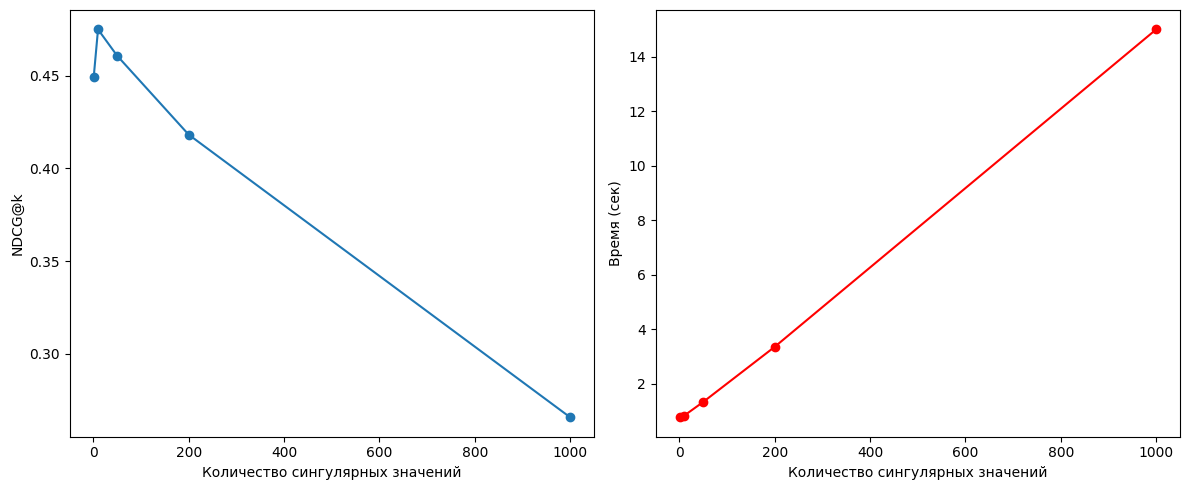

In [83]:
# Для разреженной матрицы (coo_interactions)
plot_graphs(coo_interactions, df_test, top_k=100)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [91]:
import os
import implicit
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from typing import Union


os.environ['OPENBLAS_NUM_THREADS'] = '1'

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_matrix], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
) -> np.ndarray:
    if isinstance(interactions, coo_matrix):
        interactions_csr = interactions.tocsr()
    else:
        interactions_csr = csr_matrix(interactions.astype(np.float32))
    
    model = implicit.als.AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha,
        iterations=20,
        random_state=42
    )
    
    model.fit(interactions_csr)
    

    n_users = interactions_csr.shape[0]
    recommendations = np.zeros((n_users, top_k), dtype=np.int32)
    
    for user_id in range(n_users):

        recs, _ = model.recommend(user_id, interactions_csr[user_id], N=top_k)
        recommendations[user_id] = recs
    
    return recommendations

In [92]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=0.5, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=0.5, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=0.5, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=1.0, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=1.0, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=1.0, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=2.0, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=2.0, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=50, alpha=2.0, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=0.5, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=0.5, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=0.5, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=1.0, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=1.0, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=1.0, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=2.0, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=2.0, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=100, alpha=2.0, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=0.5, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=0.5, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=0.5, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=1.0, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=1.0, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=1.0, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=2.0, reg=0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=2.0, reg=0.01


  0%|          | 0/20 [00:00<?, ?it/s]

Testing: factors=200, alpha=2.0, reg=0.1


  0%|          | 0/20 [00:00<?, ?it/s]

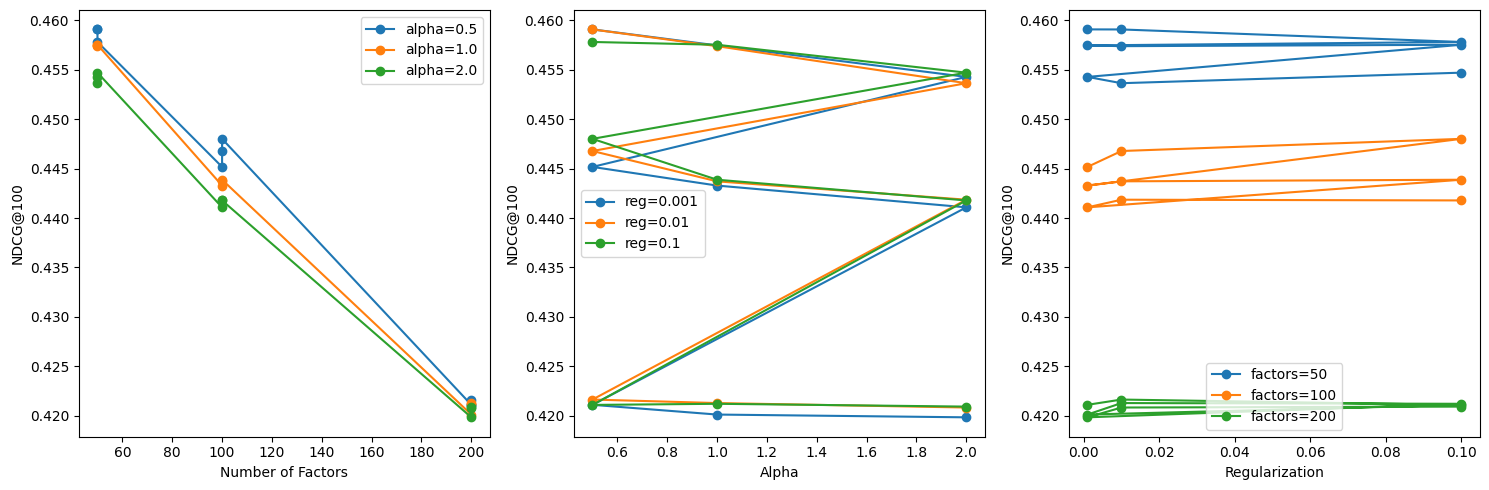

Лучшие параметры:
n_factors         50.000000
alpha              0.500000
regularization     0.001000
ndcg               0.459076
Name: 0, dtype: float64

Топ-5 комбинаций:
   n_factors  alpha  regularization      ndcg
0         50    0.5           0.001  0.459076
1         50    0.5           0.010  0.459071
2         50    0.5           0.100  0.457805
5         50    1.0           0.100  0.457522
3         50    1.0           0.001  0.457456


In [93]:
import os
import implicit
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from typing import Union
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
from itertools import product


os.environ['OPENBLAS_NUM_THREADS'] = '1'

def calculate_ndcg(test_df, recommendations, k=100):
    ndcg_scores = []
    for user_id in range(recommendations.shape[0]):
        pred_items = recommendations[user_id, :k]
        true_items = test_df[test_df['user_id'] == user_id]['item_id'].values
        
        if len(true_items) == 0:
            continue  
        

        y_true = np.isin(pred_items, true_items).astype(int)
        

        ndcg = ndcg_score([y_true], [np.ones_like(y_true)], k=k)
        ndcg_scores.append(ndcg)
    
    return np.mean(ndcg_scores)

def evaluate_als_hyperparameters(
    interactions: Union[np.ndarray, coo_matrix],
    test_df,
    top_k: int = 100,
    n_factors_list: list = [50, 100, 200],
    alpha_list: list = [0.5, 1.0, 2.0],
    regularization_list: list = [0.001, 0.01, 0.1],
    iterations: int = 20
):

    results = []
    

    if isinstance(interactions, coo_matrix):
        interactions_csr = interactions.tocsr()
    else:
        interactions_csr = csr_matrix(interactions.astype(np.float32))
    
    # Перебираем все комбинации гиперпараметров
    for n_factors, alpha, regularization in product(n_factors_list, alpha_list, regularization_list):
        print(f"Testing: factors={n_factors}, alpha={alpha}, reg={regularization}")
        
        # Создаем и обучаем модель
        model = implicit.als.AlternatingLeastSquares(
            factors=n_factors,
            regularization=regularization,
            alpha=alpha,
            iterations=iterations,
            random_state=42
        )
        model.fit(interactions_csr)
        
        # Генерируем рекомендации
        n_users = interactions_csr.shape[0]
        recommendations = np.zeros((n_users, top_k), dtype=np.int32)
        
        for user_id in range(n_users):
            recs, _ = model.recommend(user_id, interactions_csr[user_id], N=top_k)
            recommendations[user_id] = recs
        ndcg = calculate_ndcg(test_df, recommendations, top_k)
        
        results.append({
            'n_factors': n_factors,
            'alpha': alpha,
            'regularization': regularization,
            'ndcg': ndcg
        })
    
    # Преобразуем результаты в DataFrame
    import pandas as pd
    results_df = pd.DataFrame(results)
    
    # Визуализация
    plt.figure(figsize=(15, 5))
    
    # График зависимости NDCG от n_factors
    plt.subplot(1, 3, 1)
    for alpha_val in alpha_list:
        subset = results_df[results_df['alpha'] == alpha_val]
        plt.plot(subset['n_factors'], subset['ndcg'], 'o-', label=f'alpha={alpha_val}')
    plt.xlabel('Number of Factors')
    plt.ylabel('NDCG@100')
    plt.legend()
    
    # График зависимости NDCG от alpha
    plt.subplot(1, 3, 2)
    for reg_val in regularization_list:
        subset = results_df[results_df['regularization'] == reg_val]
        plt.plot(subset['alpha'], subset['ndcg'], 'o-', label=f'reg={reg_val}')
    plt.xlabel('Alpha')
    plt.ylabel('NDCG@100')
    plt.legend()
    
    # График зависимости NDCG от regularization
    plt.subplot(1, 3, 3)
    for factor_val in n_factors_list:
        subset = results_df[results_df['n_factors'] == factor_val]
        plt.plot(subset['regularization'], subset['ndcg'], 'o-', label=f'factors={factor_val}')
    plt.xlabel('Regularization')
    plt.ylabel('NDCG@100')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results_df


# Определяем диапазоны параметров
n_factors_list = [50, 100, 200]
alpha_list = [0.5, 1.0, 2.0]
regularization_list = [0.001, 0.01, 0.1]

# Запускаем оценку
results_df = evaluate_als_hyperparameters(
    interactions=interactions,
    test_df=df_test,
    top_k=100,
    n_factors_list=n_factors_list,
    alpha_list=alpha_list,
    regularization_list=regularization_list
) 
# Выводим лучшую комбинацию параметров
best_params = results_df.loc[results_df['ndcg'].idxmax()]
print("Лучшие параметры:")
print(best_params)

# Выводим топ-5 комбинаций
print("\nТоп-5 комбинаций:")
print(results_df.sort_values('ndcg', ascending=False).head(5))

##### Задание 4. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [103]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.metrics import ndcg_score

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: coo_matrix, n_iterations: int = 10):
        n_users, n_items = interactions.shape
        self.user_factors = np.random.normal(0, 0.01, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.01, (n_items, self.n_factors))
        
        eye = np.eye(self.n_factors)
        interactions_csr = interactions.tocsr()
        
        for _ in range(n_iterations):
            for u in range(n_users):
                items = interactions_csr[u].indices
                if len(items) == 0:
                    continue
                Y = self.item_factors[items]
                C = self.alpha * np.ones(len(items))
                A = Y.T @ (Y * C[:, None]) + self.reg_coef * eye
                self.user_factors[u] = np.linalg.solve(A, Y.T @ C)
            
            interactions_csc = interactions.tocsc()
            for i in range(n_items):
                users = interactions_csc[:,i].indices
                if len(users) == 0:
                    continue
                X = self.user_factors[users]
                C = self.alpha * np.ones(len(users))
                A = X.T @ (X * C[:, None]) + self.reg_coef * eye
                self.item_factors[i] = np.linalg.solve(A, X.T @ C)

    def predict(self, user_ids: np.ndarray, train_interactions: csr_matrix, top_k: int = 100) -> np.ndarray:
        scores = self.user_factors[user_ids] @ self.item_factors.T
        for i, u in enumerate(user_ids):
            interacted = train_interactions[u].indices
            scores[i, interacted] = -np.inf
        return np.argsort(-scores, axis=1)[:, :top_k]

def calculate_ndcg(model, test_interactions: coo_matrix, train_interactions: csr_matrix, top_k=100):
    test_users = np.unique(test_interactions.row)
    recs = model.predict(test_users, train_interactions, top_k)
    
    ndcg_scores = []
    for i, user in enumerate(test_users):
        true_items = test_interactions.col[test_interactions.row == user]
        pred_items = recs[i]
        y_true = np.isin(pred_items, true_items).astype(int)
        if y_true.sum() > 0:
            ndcg = ndcg_score([y_true], [np.ones_like(y_true)], k=top_k)
            ndcg_scores.append(ndcg)
    return np.mean(ndcg_scores) if ndcg_scores else 0.0

n_users, n_items = 1000, 500
data = []
for u in range(n_users):
    items = np.random.choice(n_items, size=10, replace=False)
    data.extend([(u, i, 1) for i in items])
rows, cols, _ = zip(*data)
interactions = coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(n_users, n_items))

train_csr = interactions.tocsr()

test_rows = []
test_cols = []
for u in range(n_users):
    items = train_csr[u].indices
    if len(items) > 0:
        test_item = np.random.choice(items)
        test_rows.append(u)
        test_cols.append(test_item)
        train_csr[u, test_item] = 0
train_csr.eliminate_zeros()
test = coo_matrix((np.ones(len(test_rows)), (test_rows, test_cols)), shape=(n_users, n_items))

model = iALS(n_factors=50, alpha=1.0, reg_coef=0.01)
model.fit(train_csr, n_iterations=10)
ndcg = calculate_ndcg(model, test, train_csr)
print(f"NDCG iALS: {ndcg:.4f}")

NDCG iALS: 0.2094
